### Creating a Deep Neural Network from scratch (i.e. using only numpy) to determine whether a given patient has diabetes or not.

We will implement a binary classification neural network with two hidden layers and train it using a dataset on diabetes in Pima Indians. The project will be divided into sections::

- [0: Data preparation](#1)
- [1: Initialisation of hyperparameters](#2)
- [2: Forward propagation](#3)
- [3: Back propagation](#4)
- [4: Updating parameters](#5)
- [5: Testing and evaluation](#6)

We will use a Neural Network with two hidden layers, each consisting of five nodes. The activation functions are fixed to be LINEAR -> RELU -> RELU -> Sigmoid, although this can be easily generalised.

## 0: Data preparation

We will use the Pima Indians database, which includes data collected from a group of female Pima Indians all aged 21 or older. It contains the following features:

- Pregnancies
- Glucose: plasma glucose concentration after a 2-hour oral glucose tolerance test. 

- SkinThickness: Skin fold thickness.

- Insulin: 2-Hour serum insulin (mu U/ml).

- BMI (Body Mass Index): Weight in kg / (height in m)^2

- DiabetesPedigreeFunction: A function that measures the likelihood of diabetes based on family history.

- Age: The age of the patient.

- The target variable is whether the patient has diabetes or not; 1: Diabetes (positive) and 0: No diabetes (negative)

This dataset has 768 instances.

In [9]:
# importing the necessary packages
import math
import numpy as np   # for various mathematical operations (e.g. forward and back proagation)
import pandas as pd  # for processing the dataset
import copy

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Load and Preprocess the Dataset
# -------------------------------

# URL for the Pima Indians Diabetes Dataset (no header provided)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Define column names (last column is the binary class label)
columns = ["num_pregnant", "glucose", "blood_pressure", "skin_thickness",
           "insulin", "BMI", "diabetes_pedigree", "age", "class"]

# Load the dataset
df = pd.read_csv(url, header=None, names=columns)

# Separate features and labels
X = df.drop("class", axis=1).values  # shape: (n_samples, n_features)
y = df["class"].values.reshape(-1, 1)  # shape: (n_samples, 1)

# Standardize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # shape remains (n_samples, n_features)

# Our neural network code expects data in the shape (n_features, n_samples),
# so we transpose the arrays:
X_scaled = X_scaled.T  # shape: (n_features, n_samples)
y = y.T                # shape: (1, n_samples)

# Optionally, split into training and test sets (e.g., 80/20 split)
# Note: We need to transpose the data before and after splitting since train_test_split expects samples as rows.
X_train, X_test, y_train, y_test = train_test_split(X_scaled.T, y.T, test_size=0.2, random_state=42)
X_train = X_train.T  # shape: (n_features, n_train_samples)
X_test = X_test.T    # shape: (n_features, n_test_samples)
y_train = y_train.T  # shape: (1, n_train_samples)
y_test = y_test.T    # shape: (1, n_test_samples)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8, 614)
y_train shape: (1, 614)
X_test shape: (8, 154)
y_test shape: (1, 154)


#### Let's print a subset of the data to understand what we're dealing with.

In [11]:
# Assuming the following have been defined:
# X_train: shape (n_features, n_train_samples)
# y_train: shape (1, n_train_samples)
# And the columns for the features are:
feature_names = ["num_pregnant", "glucose", "blood_pressure", "skin_thickness",
                 "insulin", "BMI", "diabetes_pedigree", "age"]

# Convert training data into a DataFrame
df_train = pd.DataFrame(X_train.T, columns=feature_names)
df_train["class"] = y_train.T  # Add the labels as a column

# Now display the first few rows of the training set
print(df_train.head())


   num_pregnant   glucose  blood_pressure  skin_thickness   insulin       BMI  \
0     -0.547919 -1.154694       -3.572597       -1.288212 -0.692891 -4.060474   
1      1.530847 -0.278373        0.666618        0.217261 -0.692891 -0.481351   
2     -0.844885  0.566649       -1.194501       -0.096379  0.027790 -0.417892   
3     -1.141852  1.255187       -0.987710       -1.288212 -0.692891 -1.280942   
4      0.639947  0.410164        0.563223        1.032726  2.519781  1.803195   

   diabetes_pedigree       age  class  
0          -0.507006 -1.041549      0  
1           2.446670  1.425995      1  
2           0.550035 -0.956462      0  
3          -0.658012  2.702312      0  
4          -0.706334  1.085644      1  


#### How about something more visual? Let's compare two features, Glucose and BMI.

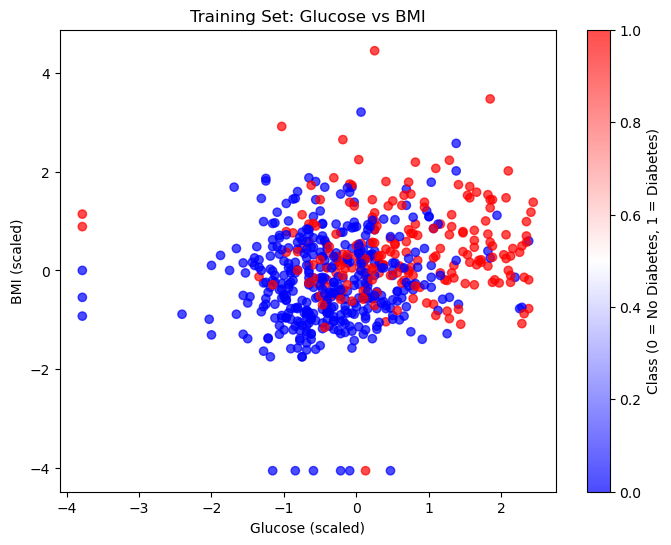

In [12]:
import matplotlib.pyplot as plt

# Visualize part of the training set by plotting 'glucose' vs 'BMI'
# X_train has shape (n_features, n_train_samples)
plt.figure(figsize=(8, 6))
plt.scatter(X_train[1, :], X_train[5, :], c=y_train.flatten(), cmap='bwr', alpha=0.7)
plt.xlabel('Glucose (scaled)')
plt.ylabel('BMI (scaled)')
plt.title('Training Set: Glucose vs BMI')
plt.colorbar(label='Class (0 = No Diabetes, 1 = Diabetes)')
plt.show()


Next, we define the activation functions that we will use.

In [13]:
# Create a class which contains the activation functions we will use

class Activation():

    def __init__(self):
        pass  ## Nothing to initialise

    @staticmethod  # We use a static method since there is no need to reference self.
    def sigmoid(x):
        x = np.clip(x, -500, 500)
        return 1/ (1 + np.exp(-x))

    @staticmethod
    def relu(x):
        return np.maximum(0,x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

## 1: Initialisation
We create a function initialize_parameters which generates the weights for each layer in the network. We use the np.random function and multiply by 0.01 to 'normalise' the data for optimal performance.

In [16]:
# Initialize the hyperparameters

L = 2  # Number of hidden layers
depth_layers = (X_train.shape[0], 5, 5, 1) # Dimensions of layers

def initialize_parameters(n_x, n_h):
    # INPUTS
    # n_x = size of input layer (array)
    # layers_h = sizes of hidden layers (array)
    # n_y = size of output layer 
    
    # OUTPUTS
    # dictionary with weights Wi and bi for i = 1, ..., L    

    weights = {}
    for i in range(1, len(n_h)):
        #w_name = f'W{i}'
        weights["W" + str(i)] = np.random.randn(n_h[i], n_h[i-1]) * 0.1

        #b_name = f'b{i}'
        weights["b" + str(i)] = np.zeros((n_h[i], 1))
    
    return weights

## 2: Forward Propagation
Now let's write the function that performs the forward pass.

In [17]:
## Now we create a function which performs a forward pass over one layer

activation_fns = [Activation.leaky_relu, Activation.leaky_relu, Activation.leaky_relu, Activation.sigmoid]

weights = initialize_parameters(X_train.shape[0], depth_layers)

def forward(activations, weights, X):
    ## INPUTS:
    # activations: an array which contains the activation functions we will use (in order)
    # weights:  dictionary containing the weights Wi and bi

    ## OUTPUTS:
    # cache: an array containing the outputs (with/without activation) after each layer
    # cache = [Z0, Z1, A1, Z2, A2, Z3, A3]
    cache = {"A0" : X}
    
    for i in range(1, len(depth_layers)):
        #Wi = weights["W" + str(i)]
        cache["Z" + str(i)] = np.dot(weights["W" + str(i)], cache["A" + str(i-1)]) + weights["b" + str(i)]
        cache["A" + str(i)] = activation_fns[i](cache["Z"+str(i)])

    return cache

We will also need a function that computes the cost. For the cost function, we choose the cross-entropy cost $J$, defined as $$ -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [18]:
def compute_cost(AL, Y):
    ## INPUTS:
    # AL -- vector corresponding to label predictions, shape (1, number of examples)
    # Y -- true "label" vector (for example: containing 0 if non-hazardous, 1 if hazardous), shape (1, number of examples)

    # OUTPUTS:
    # cost -- cross-entropy cost
    m = Y.shape[1]

    k = 1e-10  # Add k to avoid log(0) errors occuring
    cost = - (np.sum( Y * np.log(AL + k) + (1-Y) * np.log(1-AL +k), axis=1, keepdims = True)) / m
    
    cost = np.squeeze(cost)      # To make sure the cost's shape is as expected (e.g. it turns [[7]] into 7).
    
    return cost

## 3: Back propagation

In this step, we calculate the gradients of our loss function with respect to the activations, weights and biases of each layer.

For each $l$, the three gradients $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.
Here are the expressions for the gradients:d:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

Of course, to use these formulas we will first need to compute $dZ^{[l]}$ for each layer $l$. This is done in the backward function below and stored in a dictionary labelled dZ.

In [19]:
## Now we perform the backpropagation
# We will need the derivatives of our activation functions, so let's define those first.

def relu_grad(x):
        return (x > 0) * 1

def sigmoid_grad(x):
        return Activation.sigmoid(x)*(1-Activation.sigmoid(x))

def linear_grad(x):
    return np.ones_like(x)
        
# Now we define a function which does backprop over one layer.
def backward(cache, Y, weights):
    ## INPUTS:
    # cache: a dictionary containing all the weights

    ## OUTPUTS:
    # grads: a dictionary containing all the gradients
    
    m = Y.shape[1]  # letting m be the number of training examples

    # Creating the dictionary dZ which will store the gradients dL/Dz^i
    dZ = {"dZ3" : cache["A" + str(3)] - Y}
    dZ["dZ2"] = np.multiply(np.dot(weights["W" + str(3)].T, dZ["dZ3"]), relu_grad(cache["Z" + str(2)]))
    # dZ["dZ1"] = np.dot(weights["W" + str(2)].T, dZ["dZ2"])
    dZ["dZ1"] = np.multiply(np.dot(weights["W2"].T, dZ["dZ2"]), relu_grad(cache["Z1"]))



    # Y1 and Y2 appear in the cost function, so we define them first for more readable computations.
    Y1 = np.multiply(Y, 1/ (cache["A" + str(3)]))
    Y2 = np.multiply((1-Y), 1 / (cache["A" + str(3)]))
    
    # Now we calculate the gradients for each layer using the formulas above.
    grads = {}
    for i in range (1, len(depth_layers)):
        grads["dW" + str(i)] = ( np.dot(dZ["dZ" + str(i)], cache["A" + str(i-1)].T ) ) / m
        grads["db" + str(i)] = ( np.sum(dZ["dZ" + str(i)], axis=1, keepdims = True) ) / m
        grads["dA" + str(i-1)] = ( np.dot(weights["W" + str(i)].T, dZ["dZ" + str(i)]))

    return grads

## 4: Updating the parameters
We write a function which updates the parameters using a standard gradient descent approach.

Recall that the update rule for gradient descent reads as $$\theta_{k+1} = \theta_{k} - \alpha \nabla \mathcal{J}(\theta_{k}) $$ where $\alpha$ is the learning rate.

In [20]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    N = len(parameters)

    # Update rule for each parameter
    for l in range(1, len(depth_layers)):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
    
    return parameters

In [21]:
def two_layer_model(X, Y, depth_layers, learning_rate = 0.001, num_iterations=2000, print_cost=False):
    """
    Implements a 2-layer neural network: [RELU]*(L-1)->SIGMOID.
    
    INPUTS:
    X -- input data
    Y -- true label vector of shape (1, number of examples)
    depth_layers -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate for the gradient descent update
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    OUTPUTS:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []

    weights = initialize_parameters(X.shape[0], depth_layers)

    for i in range(0, num_iterations):
        cache = forward(activation_fns, weights, X)  # Forward pass, returning cache an array of outputs [Z0, A0, ... , Z3 ,A3]
        cost = compute_cost(cache["A" + str(3)], Y)  # Computing the cost
        grads = backward(cache, Y, weights) # Backward pass, returning grads [dWi, dbi, dAi for i = 1,2,3]
        weights = update_parameters(weights, grads, learning_rate)  # Updating the cache array with new parameters.
        
        costs.append(cost)
    
    return cache, costs, weights

# 5: Testing and evaluation

First, we train the model for 50,000 iterations and evaluate its performance on the test set.

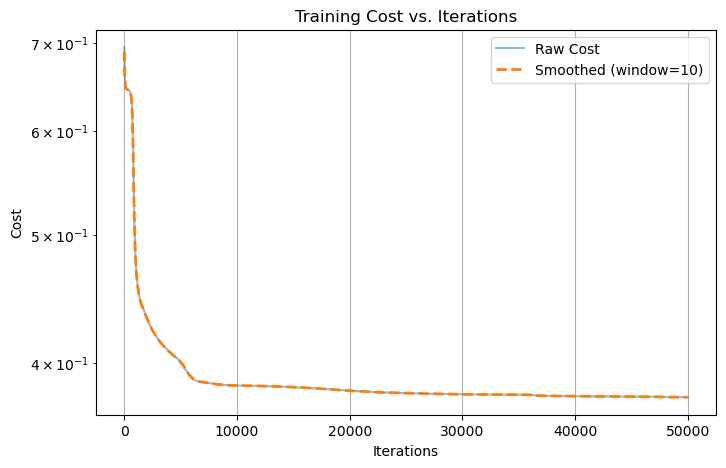

Training Accuracy: 82.41%
Test Accuracy: 72.73%


In [36]:
import matplotlib.pyplot as plt

N = 50000

parameters, costs, weights = two_layer_model(X_train, y_train, (X_train.shape[0], 5, 5, 1), learning_rate = 0.05, num_iterations=N)


def plot_costs(costs, N, window=10):
    """
    Plots the evolution of cost with iterations, including a smoothed curve.
    """
    x_range = np.arange(1, N + 1)

    # Compute moving average for smoothing
    smoothed_costs = np.convolve(costs, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(8, 5))
    plt.plot(x_range, costs, label="Raw Cost", alpha=0.5)
    plt.plot(x_range[:len(smoothed_costs)], smoothed_costs, label=f"Smoothed (window={window})", linewidth=2, linestyle="--")

    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Training Cost vs. Iterations')
    plt.yscale("log")  # Log scale for better visibility
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_costs(costs, N)

# Let's also evaluate the model on the training and test sets.
def predict(weights, X):
    """
    Carries out the forward propagation and returns binary predictions.
    """
    cache = forward(activation_fns, weights, X)
    return (cache["A3"] > 0.4).astype(int)

def compute_accuracy(predictions, labels):
    return np.mean(predictions == labels) * 100

def predict_with_threshold(weights, X, threshold=0.2):
    cache = forward(activation_fns, weights, X)
    return (cache["A3"] > threshold).astype(int)

test_predictions = predict_with_threshold(weights, X_test, threshold=0.2)

# Predictions
train_predictions = predict(weights, X_train)
test_predictions = predict(weights, X_test)

# Accuracy
train_acc = compute_accuracy(train_predictions, y_train)
test_acc = compute_accuracy(test_predictions, y_test)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

#### For imbalanced datasets, the accuracy on the training and test sets may not suffice, so we also calculate precision, recall and the F score. 

In [46]:
# Function which computes accuracy, precision, recall, and F1 score
def test_model(X, Y, weights):
    activations = [Activation.relu, Activation.relu, Activation.sigmoid]
    cache = forward(activations, weights, X)
    AL = cache[f"A{len(activations)}"]
    predictions = (AL >= 0.5).astype(int)
    
    # Accuracy
    accuracy = np.mean(predictions == Y)
    
    # Flatten arrays for metric computation
    Y_flat = Y.flatten()
    pred_flat = predictions.flatten()
    
    TP = np.sum((pred_flat == 1) & (Y_flat == 1))
    FP = np.sum((pred_flat == 1) & (Y_flat == 0))
    FN = np.sum((pred_flat == 0) & (Y_flat == 1))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1


acc, prec, rec, f1 = test_model(X_test, y_test, weights)
print("Test Accuracy: {:.2%}".format(acc))
print("Test Precision: {:.2%}".format(prec))
print("Test Recall: {:.2%}".format(rec))
print("Test F1 Score: {:.2%}".format(f1))

Test Accuracy: 75.97%
Test Precision: 67.31%
Test Recall: 63.64%
Test F1 Score: 65.42%


#### We can also compute a confusion matrix which helps to evaluate our model.

Confusion Matrix:
[[82 17]
 [20 35]]


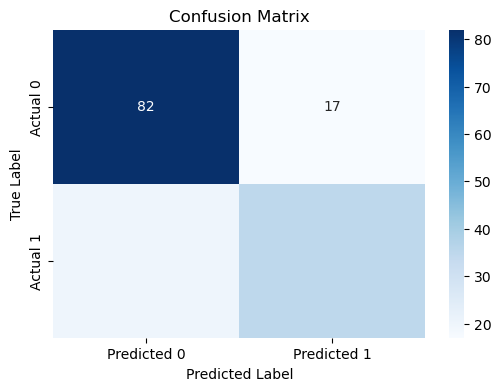

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def display_confusion_matrix(X, Y, weights):
    """
    Calculates and displays the confusion matrix for the neural network predictions.

    Parameters:
      X : np.array of shape (n_features, n_samples)
         The input data.
      Y : np.array of shape (1, n_samples)
         The true binary labels.
      weights : dict
         The trained network parameters.
    """
    # Use the same activations as during training
    activations = [Activation.relu, Activation.relu, Activation.sigmoid]
    cache = forward(activations, weights, X)
    
    # This is the final output
    AL = cache[f"A{len(activations)}"]
    
    # Converting probabilities to binary predictions with a threshold of 0.5
    predictions = (AL >= 0.5).astype(int)
    
    # Calculate confusion mat, first flatten the arrays
    y_true = Y.flatten()
    y_pred = predictions.flatten()
    cm = confusion_matrix(y_true, y_pred)
    
    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Visualisation using a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# use it on the test set
display_confusion_matrix(X_test, y_test, weights)